# Image Super-Resolution using an Efficient Sub-Pixel CNN

**Author:** [Xingyu Long](https://github.com/xingyu-long)<br>
**Date created:** 2020/07/28<br>
**Last modified:** 2020/08/27<br>
**Description:** Implementing Super-Resolution using Efficient sub-pixel model on BSDS500.<br>
**Translate:** [Junghyun Park](https://github.com/parkjh688)

## 시작하기

ESPCN (Efficient Sub-Pixel CNN)은, [Shi, 2016](https://arxiv.org/abs/1609.05158)가 제안한 모델로 저해상도 이미지를 고해상도로 변환하는 모델입니다. 효율적인 "서브-픽셀 컨볼루션" 레이어를 활용하여 다양한 이미지 업스케일링 필터를 학습합니다.

이 코드 예제에서는, 논문의 모델을 구현하고 소규모 데이터 셋인 [BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html)에 대해 모델을 학습합니다.

In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## 데이터 가져오기: BSDS500

### 데이터셋 다운로드

우리는 데이터를 다운받기 위해 내장된(built-in) `~keras.utils.get_file` 유틸리티를 사용합니다.

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70770688/70763455 [==============================] - 2s 0us/step


우리는 `image_dataset_from_directory`을 이용해 training, validation 데이터셋을 만듭니다.

In [3]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


이미지를 [0, 1]로 리스케일링 합니다.

In [4]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

몇 개의 샘플 이미지를 시각화해봅시다:

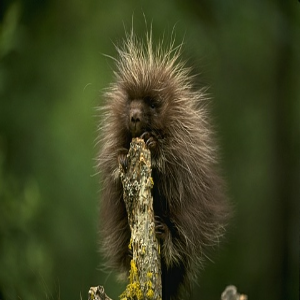

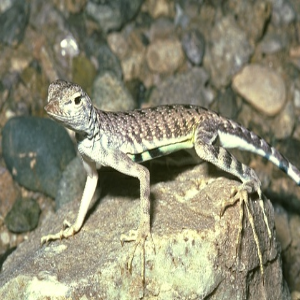

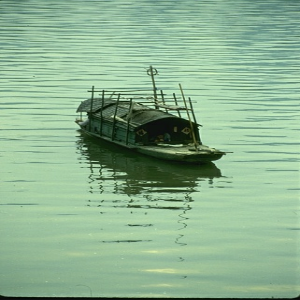

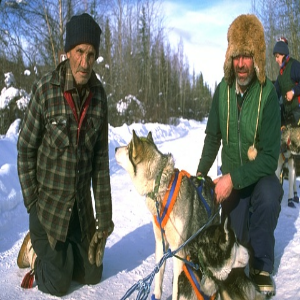

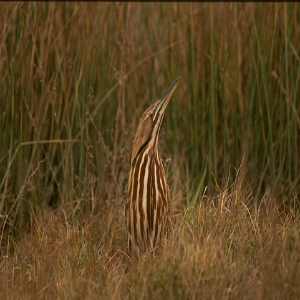

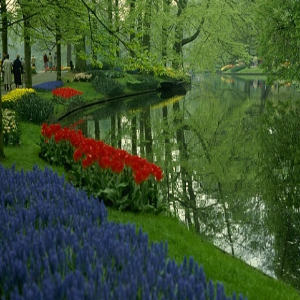

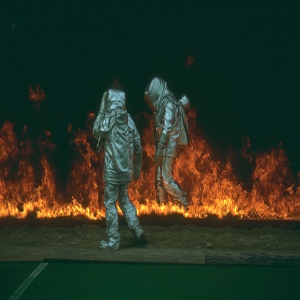

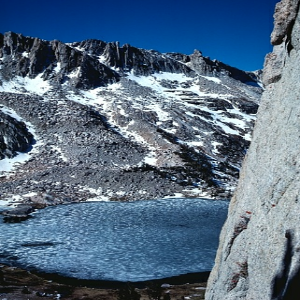

In [5]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

이 예제의 마지막에 시각적 평가에 사용할 테스트 데이터 셋의 이미지 경로를 준비합니다.

In [6]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

## 이미지를 자르고 리사이즈 하자

이미지 데이터 처리를 해봅시다.
첫 째, RGB 컬러 스페이스를 가진 우리의 이미지를 [YUV](https://en.wikipedia.org/wiki/YUV) 컬러 스페이스로 바꿔줍시다.

입력 데이터 (저해상도 이미지)의 경우 이미지를 자르고, y 채널(luninance)을 찾고, `area` 메소드 사용하여 크기를 조정합니다(PIL을 사용하는 경우 `BICUBIC` 사용). 
우리는 인간이 휘도 변화에 더 민감하기 때문에 YUV 색상 공간의 휘도 채널만 고려합니다.

타겟 데이터 (고해상도 이미지)의 경우 이미지를 자르기만 하면 됩니다 그리고 y 채널을 찾습니다.

In [7]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input) # rgb -> yuv
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis) # y, u, v 채널별로 split
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

입력 데이터와 타겟 데이터를 조금 살펴봅시다.

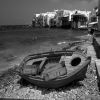

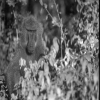

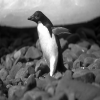

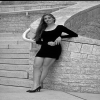

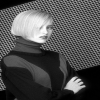

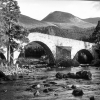

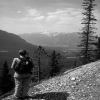

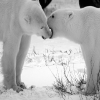

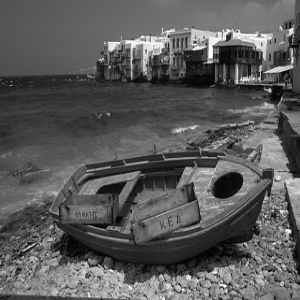

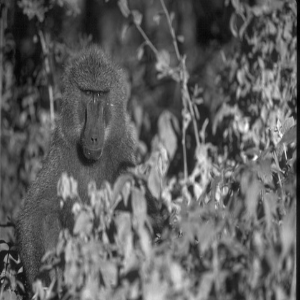

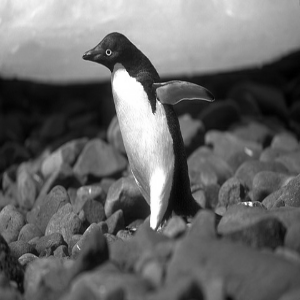

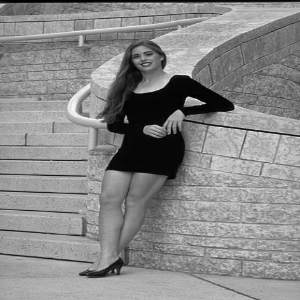

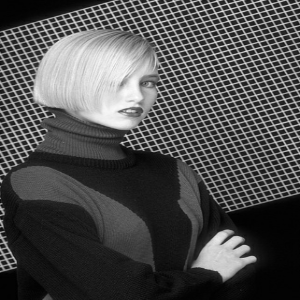

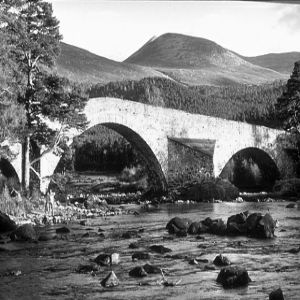

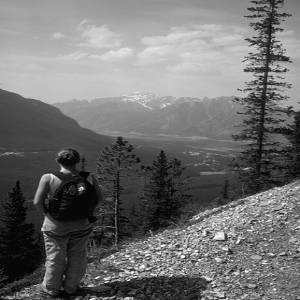

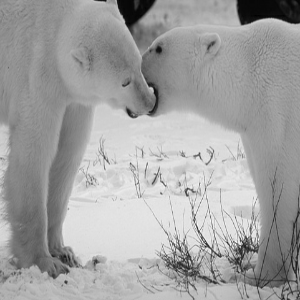

In [8]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


## 모델 만들기

논문과 비교해서, 우리는 한가지 레이어를 추가하고 `tanh` 활성함수 대신 `relu`를 사용할 것 입니다.
이것은 우리가 몇 에폭 학습시키지 않아도 더 나은 퍼포먼스가 나오도록 합니다.

In [10]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## tf.nn.depth_to_space

`depth`의 데이터를 공간적인 데이터의 블록으로 재배열합니다. SpaceToDepth 함수의 역과정과 같습니다. 구체적으로, 이 함수는 depth 차원의 값들을 height와 width 차원들의 공간적인 블록으로 이동시킵니다. block_size는 입력의 블록 크기와 데이터가 어떻게 이동될지를 지정합니다.

## 유틸리티 함수 정의하기

우리는 우리의 결과물을 모니터링 하기 위해 유틸리티 함수 몇 가지를 정의해야 합니다:

- `plot_results`는 저장한 이미지를 보여줍니다.
- `get_lowres_image`는 이미지를 저해상도로 바꿔줍니다.
- `upscale_image`는 모델을 이용해 저해상도의 이미지를 고해상도로 변환시켜줍니다.

이 함수에서, 우리는 YUV 컬러 스페이스의 `y`채널을 모델 입력으로 사용하고 출력과 다른 채널을 결합하여 RGB 영상을 얻습니다.

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """줌-인 구간 플롯팅"""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """모델에 입력으로 사용할 저해상도 이미지 값 만들기"""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """학습시킨 모델을 이용해 저해상도의 이미지를 고해상도로 변환 및 이미지를 RGB이미지로 변환"""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## 학습 모니터링을 위한 콜백 정의하기

`ESPCNCallback` 객체는 [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) 메트릭을 계산하고 보여줍니다. 이것은 super-resolution의 퍼포먼스를 평가하는데 많이 쓰이는 방법 입니다.

In [12]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



`ModelCheckpoint`와 `EarlyStopping` 콜백도 정의합니다.

In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

## 모델 학습하기

Epoch 1/100
Mean PSNR for epoch: 22.18


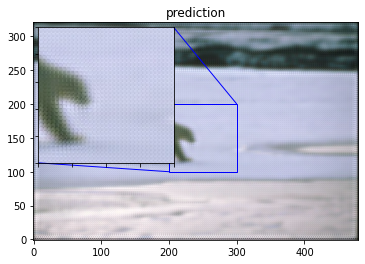

50/50 - 45s - loss: 0.0251 - val_loss: 0.0061
Epoch 2/100
Mean PSNR for epoch: 24.68
50/50 - 45s - loss: 0.0047 - val_loss: 0.0033
Epoch 3/100
Mean PSNR for epoch: 25.59
50/50 - 45s - loss: 0.0034 - val_loss: 0.0029
Epoch 4/100
Mean PSNR for epoch: 26.19
50/50 - 44s - loss: 0.0032 - val_loss: 0.0027
Epoch 5/100
Mean PSNR for epoch: 26.01
50/50 - 44s - loss: 0.0029 - val_loss: 0.0026
Epoch 6/100
Mean PSNR for epoch: 26.26
50/50 - 44s - loss: 0.0029 - val_loss: 0.0025
Epoch 7/100
Mean PSNR for epoch: 26.29
50/50 - 44s - loss: 0.0028 - val_loss: 0.0025
Epoch 8/100
Mean PSNR for epoch: 26.20
50/50 - 44s - loss: 0.0028 - val_loss: 0.0025
Epoch 9/100
Mean PSNR for epoch: 26.42
50/50 - 45s - loss: 0.0027 - val_loss: 0.0024
Epoch 10/100
Mean PSNR for epoch: 26.25
50/50 - 45s - loss: 0.0027 - val_loss: 0.0024
Epoch 11/100
Mean PSNR for epoch: 26.32
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024
Epoch 12/100
Mean PSNR for epoch: 26.11
50/50 - 44s - loss: 0.0027 - val_loss: 0.0024
Epoch 13/100
Mea

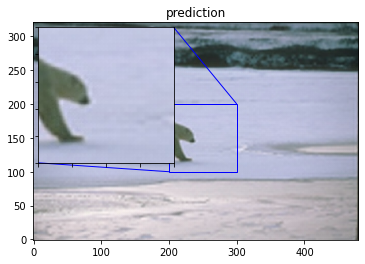

50/50 - 45s - loss: 0.0026 - val_loss: 0.0023
Epoch 22/100
Mean PSNR for epoch: 26.28
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 23/100
Mean PSNR for epoch: 26.67
50/50 - 45s - loss: 0.0026 - val_loss: 0.0023
Epoch 24/100
Mean PSNR for epoch: 26.72
50/50 - 45s - loss: 0.0026 - val_loss: 0.0023
Epoch 25/100
Mean PSNR for epoch: 27.03
50/50 - 44s - loss: 0.0028 - val_loss: 0.0023
Epoch 26/100
Mean PSNR for epoch: 26.37
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 27/100
Mean PSNR for epoch: 27.25
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 28/100
Mean PSNR for epoch: 26.59
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 29/100
Mean PSNR for epoch: 26.67
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 30/100
Mean PSNR for epoch: 26.49
50/50 - 46s - loss: 0.0026 - val_loss: 0.0023
Epoch 31/100
Mean PSNR for epoch: 26.18
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 32/100
Mean PSNR for epoch: 26.54
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 33

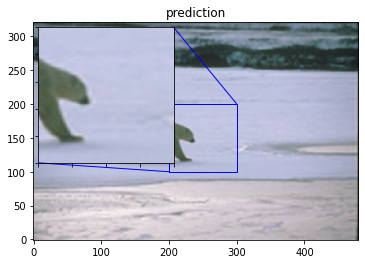

50/50 - 45s - loss: 0.0025 - val_loss: 0.0023
Epoch 42/100
Mean PSNR for epoch: 26.73
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 43/100
Mean PSNR for epoch: 26.87
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 44/100
Mean PSNR for epoch: 26.86
50/50 - 45s - loss: 0.0025 - val_loss: 0.0023
Epoch 45/100
Mean PSNR for epoch: 26.49
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 46/100
Mean PSNR for epoch: 26.28
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 47/100
Mean PSNR for epoch: 26.60
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 48/100
Mean PSNR for epoch: 26.37
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 49/100
Mean PSNR for epoch: 26.55
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 50/100
Mean PSNR for epoch: 26.41
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 51/100
Mean PSNR for epoch: 26.74
50/50 - 45s - loss: 0.0025 - val_loss: 0.0022
Epoch 52/100
Mean PSNR for epoch: 26.47
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 53

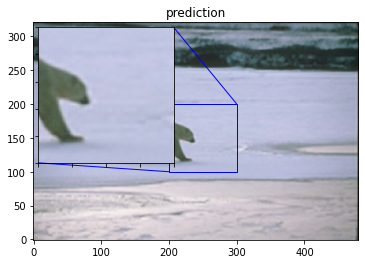

50/50 - 45s - loss: 0.0025 - val_loss: 0.0022
Epoch 62/100
Mean PSNR for epoch: 26.26
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 63/100
Mean PSNR for epoch: 26.32
50/50 - 44s - loss: 0.0025 - val_loss: 0.0023
Epoch 64/100
Mean PSNR for epoch: 27.33
50/50 - 45s - loss: 0.0025 - val_loss: 0.0022
Epoch 65/100
Mean PSNR for epoch: 26.90
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 66/100
Mean PSNR for epoch: 26.19
50/50 - 44s - loss: 0.0026 - val_loss: 0.0024
Epoch 67/100
Mean PSNR for epoch: 26.69
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 68/100
Mean PSNR for epoch: 26.71
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 69/100
Mean PSNR for epoch: 26.46
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 70/100
Mean PSNR for epoch: 26.73
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 71/100
Mean PSNR for epoch: 26.71
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 72/100
Mean PSNR for epoch: 26.89
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 73

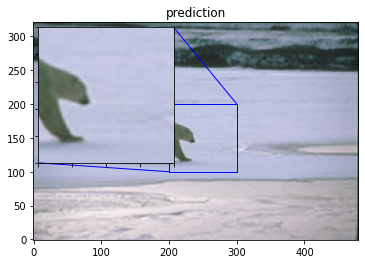

50/50 - 45s - loss: 0.0025 - val_loss: 0.0022
Epoch 82/100
Mean PSNR for epoch: 26.65
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 83/100
Mean PSNR for epoch: 26.86
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 84/100
Mean PSNR for epoch: 26.69
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 85/100
Mean PSNR for epoch: 26.84
50/50 - 45s - loss: 0.0025 - val_loss: 0.0022
Epoch 86/100
Mean PSNR for epoch: 26.17
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 87/100
Mean PSNR for epoch: 26.42
50/50 - 45s - loss: 0.0025 - val_loss: 0.0023
Epoch 88/100
Mean PSNR for epoch: 25.71
50/50 - 44s - loss: 0.0034 - val_loss: 0.0026
Epoch 89/100
Mean PSNR for epoch: 26.52
50/50 - 44s - loss: 0.0026 - val_loss: 0.0023
Epoch 90/100
Mean PSNR for epoch: 26.36
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 91/100
Mean PSNR for epoch: 26.32
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 92/100
Mean PSNR for epoch: 26.83
50/50 - 44s - loss: 0.0025 - val_loss: 0.0022
Epoch 93

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

## 모델을 통해 예측하고 결과 그려보기

이제 몇 개의 영상의 재구성(reconstructed) 버전을 계산하고 결과를 저장하겠습니다.

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.1968


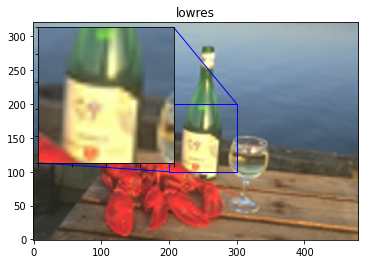

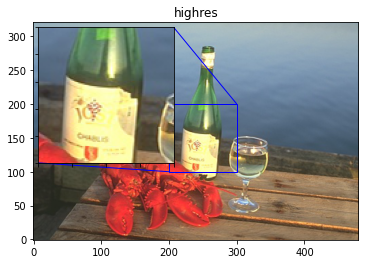

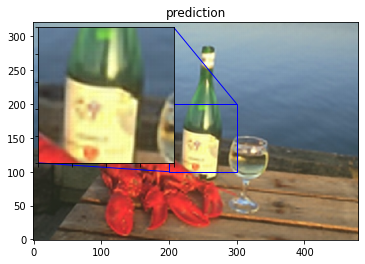

PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.8498


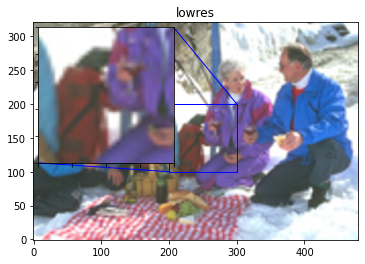

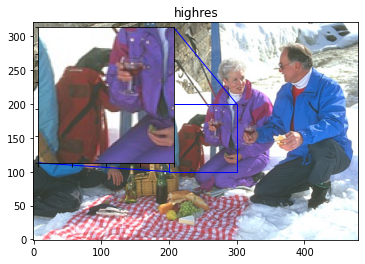

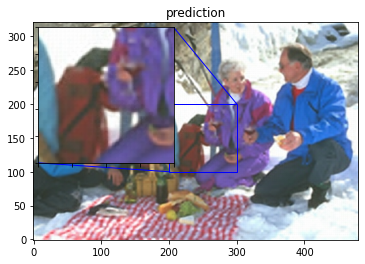

PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.2950


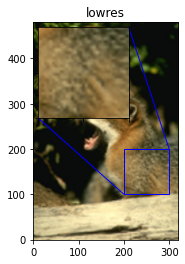

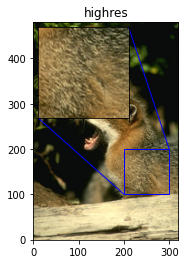

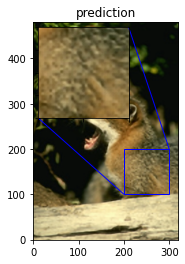

PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.2171


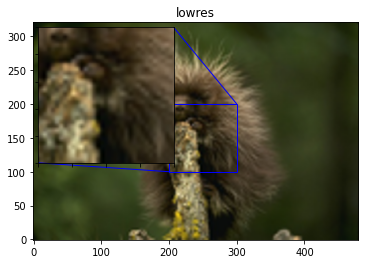

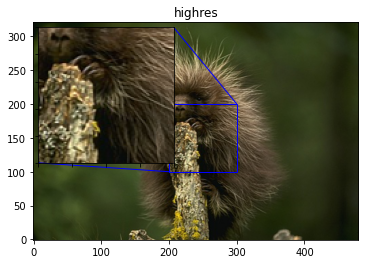

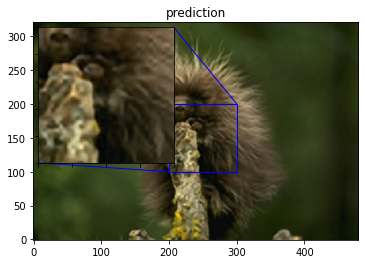

PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.2730


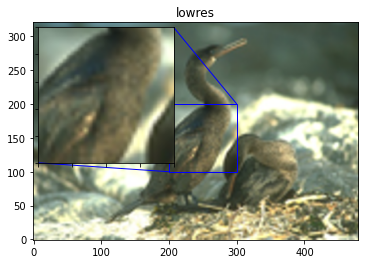

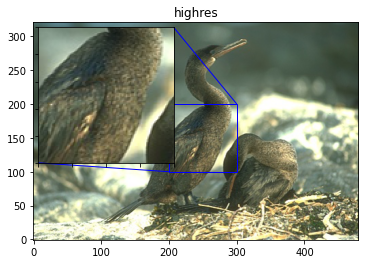

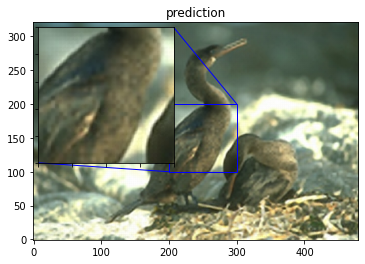

PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.5000


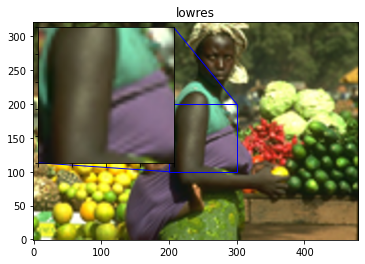

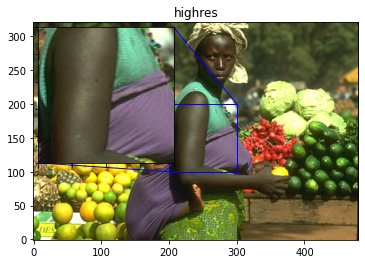

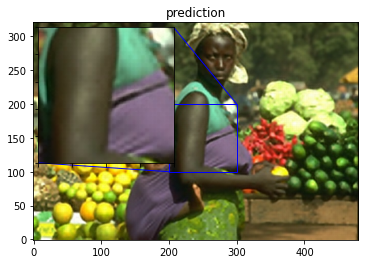

PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.0661


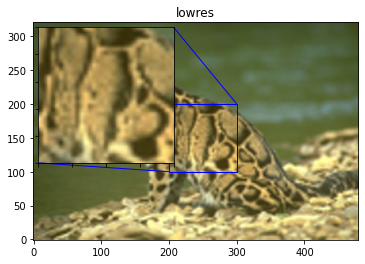

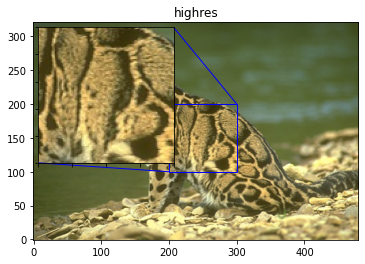

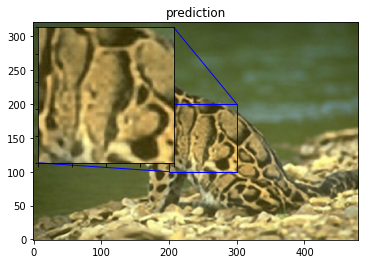

PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.7022


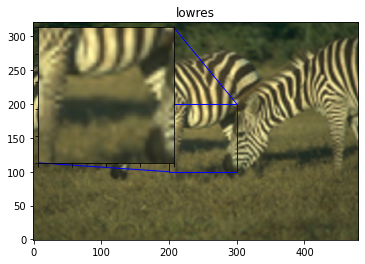

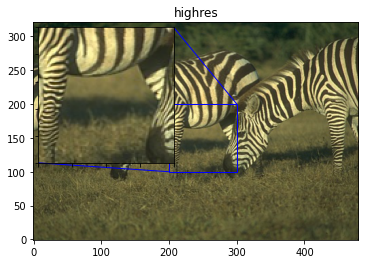

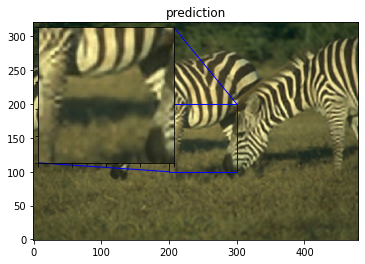

PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 29.9331


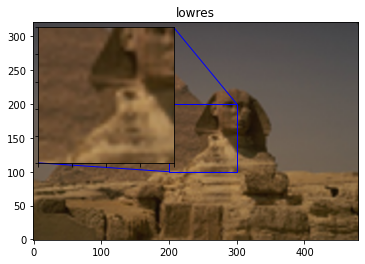

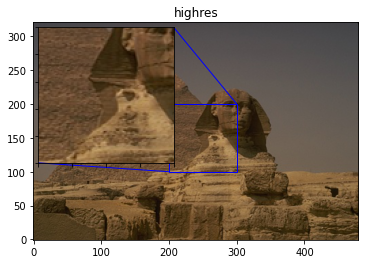

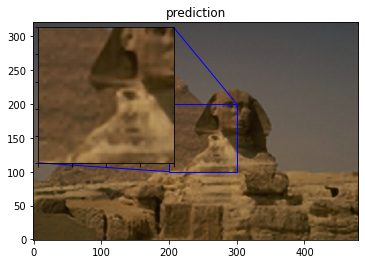

PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.6661


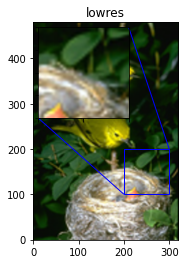

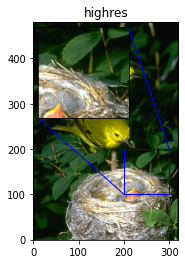

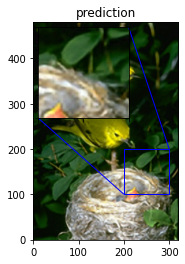

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.2699


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))